In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import time
import numpy as np
from sklearn.preprocessing import OneHotEncoder, RobustScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, Ridge, HuberRegressor, LinearRegression
from sklearn.svm import SVR
from sklearn.cluster import KMeans
from sklearn.feature_selection import mutual_info_regression
from xgboost import XGBRegressor
import catboost as cb
from mlxtend.regressor import StackingCVRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
from scipy.stats import skew, norm, probplot
from operator import itemgetter
import seaborn as sns
sns.set_style('darkgrid')
pd.set_option('display.max_columns',None)


# ***Initializing Dataset***

In [2]:
df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
y = df['SalePrice']
df = df.drop(['SalePrice'],axis=1)
df = df.set_index('Id')
test = test.set_index('Id')

# ***Missing Values Imputation***

In [4]:
print("Total null values:")
print(df.isna().sum().sum() + test.isna().sum().sum())
print("\nNull columns and counts in each dataset\n")
for col in df.columns:
    null = df[col].isnull().sum()
    test_null = test[col].isnull().sum()
    if null != 0 and test_null != 0:
        print(col,df[col].dtypes)
        print("Missing in train set:" +  str(null))
        print("Missing in test set:" + str(test_null))
        print("\n")
    elif null != 0:
        print(col,df[col].dtypes)
        print("Missing in train set:" +  str(null))
        print("\n")
    elif test_null !=0:
        print(col,test[col].dtypes)
        print("Missing in test set:" +  str(test_null))
        print("\n")
    

Total null values:
13965

Null columns and counts in each dataset

MSZoning object
Missing in test set:4


LotFrontage float64
Missing in train set:259
Missing in test set:227


Alley object
Missing in train set:1369
Missing in test set:1352


Utilities object
Missing in test set:2


Exterior1st object
Missing in test set:1


Exterior2nd object
Missing in test set:1


MasVnrType object
Missing in train set:8
Missing in test set:16


MasVnrArea float64
Missing in train set:8
Missing in test set:15


BsmtQual object
Missing in train set:37
Missing in test set:44


BsmtCond object
Missing in train set:37
Missing in test set:45


BsmtExposure object
Missing in train set:38
Missing in test set:44


BsmtFinType1 object
Missing in train set:37
Missing in test set:42


BsmtFinSF1 float64
Missing in test set:1


BsmtFinType2 object
Missing in train set:38
Missing in test set:42


BsmtFinSF2 float64
Missing in test set:1


BsmtUnfSF float64
Missing in test set:1


TotalBsmtSF float64
Missing in 

We will have to impute those missing values with the most sensable method by looking at them one at a time  

**MSZoning** : Identifies the general zoning classification of the sale.  
       A	Agriculture  
       C	Commercial  
       FV	Floating Village Residential  
       I	Industrial  
       RH	Residential High Density  
       RL	Residential Low Density  
       RP	Residential Low Density Park   
       RM	Residential Medium Density  

In [5]:
full = pd.concat([df,test],axis=0).reset_index(drop=True)

,Neighborhood,MSZoning
Id,,
1916,IDOTRR,NaN
2217,IDOTRR,NaN
2251,IDOTRR,NaN
2905,Mitchel,NaN


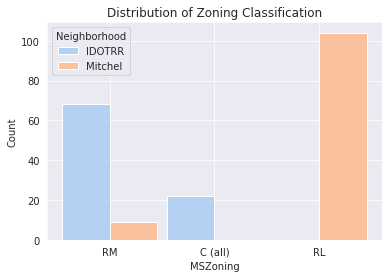

In [6]:
sns.set_palette(sns.color_palette("pastel"))
null = test[test['MSZoning'].isnull()][["Neighborhood","MSZoning"]]
display(null)
plot_data = pd.concat([full[full['Neighborhood'] == 'IDOTRR'],full[full['Neighborhood'] == 'Mitchel']],axis = 0)
sns.histplot(data = plot_data, x ='MSZoning', hue ='Neighborhood',multiple="dodge", shrink=.9)
plt.title("Distribution of Zoning Classification")
plt.show()

Since the general zoning classification usually depends on the neighborhood, we will impute the missing value by the mode in the area.

In [7]:
test.loc[(test['Neighborhood'] == 'IDOTRR') & (test['MSZoning'].isnull()), 'MSZoning'] = 'RM'
test.loc[(test['Neighborhood'] == 'Mitchel') & (test['MSZoning'].isnull()), 'MSZoning'] = 'RL'

**LotFrontage** : Linear feet of street connected to property  
We expect LotFrontage to be somewhat correlated with LotArea. Hence we will use LinearRegression to impute the missing values.

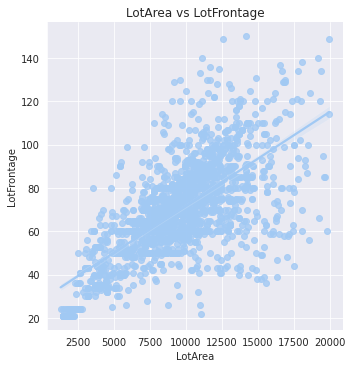

In [8]:
data = full[(~full['LotFrontage'].isnull()) & (full['LotFrontage'] <= 150) & (full['LotArea'] <= 20000)]
sns.lmplot(data=data,x="LotArea",y="LotFrontage")
plt.ylabel("LotFrontage")
plt.xlabel("LotArea")
plt.title("LotArea vs LotFrontage")
plt.show()

In [9]:
area_vs_frontage = LinearRegression()
area_vs_frontage_X = data['LotArea'].values.reshape(-1, 1)
area_vs_frontage_y = data['LotFrontage'].values
area_vs_frontage.fit(area_vs_frontage_X,area_vs_frontage_y)
for table in [df,test]:
    table['LotFrontage'].fillna(area_vs_frontage.intercept_ + table['LotArea'] * area_vs_frontage.coef_[0] , inplace=True)

**Alley** : data description says NA means no alley access

In [10]:
for table in [df,test]:
    table['Alley'].fillna("None",inplace=True)

**Utilities** : Type of utilities available

In [11]:
full['Utilities'].value_counts()

AllPub    2916
NoSeWa       1
Name: Utilities, dtype: int64

In [12]:
test['Utilities'].fillna("AllPub",inplace=True)

In [13]:
df[df['Utilities'] == 'NoSeWa'].index

Int64Index([945], dtype='int64', name='Id')

In [14]:
df.drop(945, inplace = True)

In [15]:
test['Exterior1st'] = test['Exterior1st'].fillna(full['Exterior1st'].mode()[0])
test['Exterior2nd'] = test['Exterior2nd'].fillna(full['Exterior2nd'].mode()[0])

**MasVnrType** : data description says NA means no Masonry veneer. However wo notice one data in test set with area but missing type.

In [16]:
test[(test['MasVnrType'].isnull()) & (test['MasVnrArea'].notnull())][['MasVnrType','MasVnrArea']]

,MasVnrType,MasVnrArea
Id,,
2611,NaN,198.0


In [17]:
test['MasVnrType'][2611] = full['MasVnrType'].mode()[0]
test['MasVnrType'] = test['MasVnrType'].fillna(full['MasVnrType'].mode()[0])
test['MasVnrArea'] = test['MasVnrArea'].fillna(0)
df['MasVnrType'] = df['MasVnrType'].fillna(full['MasVnrType'].mode()[0])
df['MasVnrArea'] = df['MasVnrArea'].fillna(0)

**BsmtFinType1** : data description says this metric measures the Type 1 finished square feet of basement.  
However, we can see a few data in test data set having basement metrics but "0" squarefeets

In [18]:
for basement_metrics_cols in ['BsmtExposure','BsmtCond','BsmtQual']:
    if len(full[(full[basement_metrics_cols].notnull()) & (full['BsmtFinType1'].isnull())]) > 0 :
        print("Present with BsmtFinType1 but undetected" + basement_metrics_cols)
        display(full[(full[basement_metrics_cols].notnull()) & (full['BsmtFinType1'].isnull())])

In [19]:
for basement_metrics_cols in ['BsmtExposure','BsmtCond','BsmtQual']:
    if len(full[(full[basement_metrics_cols].isnull()) & (full['BsmtFinType1'].notnull())]) > 0 :
        print("\nPresent with "+ basement_metrics_cols+" but BsmtFinType1 undetected" )
        display(full[(full[basement_metrics_cols].isnull()) & (full['BsmtFinType1'].notnull())])


Present with BsmtExposure but BsmtFinType1 undetected


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
948,60,RL,65.0,14006,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2002,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,144.0,Gd,TA,PConc,Gd,TA,NaN,Unf,0.0,Unf,0.0,936.0,936.0,GasA,Ex,Y,SBrkr,936,840,0,1776,0.0,0.0,2,1,3,1,Gd,7,Typ,1,TA,Attchd,2002.0,RFn,2.0,474.0,TA,TA,Y,144,96,0,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Normal
1487,20,RL,73.0,8987,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2005,2006,Gable,CompShg,VinylSd,VinylSd,BrkFace,226.0,Gd,TA,PConc,Gd,TA,NaN,Unf,0.0,Unf,0.0,1595.0,1595.0,GasA,Ex,Y,SBrkr,1595,0,0,1595,0.0,0.0,2,0,2,1,Gd,6,Typ,1,Gd,Attchd,2005.0,RFn,3.0,880.0,TA,TA,Y,144,0,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal
2348,60,FV,81.0,10411,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,Somerst,Norm,Norm,1Fam,2Story,5,5,2007,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,CBlock,Gd,TA,NaN,Unf,0.0,Unf,0.0,725.0,725.0,GasA,Ex,Y,SBrkr,725,863,0,1588,0.0,0.0,3,0,3,1,Gd,8,Typ,0,NaN,Attchd,2007.0,Unf,2.0,561.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,7,2007,New,Partial



Present with BsmtCond but BsmtFinType1 undetected


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
2040,20,RL,103.0,16280,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Veenker,Norm,Norm,1Fam,1Story,8,9,1976,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,Ex,Ex,CBlock,Gd,NaN,Mn,GLQ,1044.0,Rec,382.0,0.0,1426.0,GasA,Ex,Y,SBrkr,1671,0,0,1671,1.0,0.0,3,0,3,1,Ex,6,Typ,1,Gd,Attchd,1976.0,RFn,2.0,550.0,TA,TA,Y,280,90,0,0,0,0,NaN,GdWo,NaN,0,5,2008,WD,Normal
2185,20,RL,65.0,6500,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,6,6,1976,1976,Hip,CompShg,HdBoard,Plywood,BrkFace,84.0,TA,TA,CBlock,TA,NaN,No,BLQ,1033.0,Unf,0.0,94.0,1127.0,GasA,TA,Y,SBrkr,1127,0,0,1127,0.0,1.0,1,1,3,1,TA,6,Typ,1,Po,Detchd,1991.0,Unf,2.0,480.0,TA,TA,Y,0,0,138,0,0,0,NaN,NaN,NaN,0,5,2008,WD,Normal
2524,80,RL,72.0,9720,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,SLvl,5,7,1977,1977,Gable,CompShg,Plywood,VinylSd,BrkFace,51.0,TA,TA,CBlock,TA,NaN,Av,ALQ,755.0,Unf,0.0,240.0,995.0,GasA,TA,Y,SBrkr,1009,0,0,1009,0.0,0.0,2,0,3,1,TA,6,Typ,1,Fa,Detchd,1977.0,Unf,2.0,576.0,TA,TA,Y,0,0,0,0,0,0,NaN,MnPrv,NaN,0,6,2007,WD,Normal



Present with BsmtQual but BsmtFinType1 undetected


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
2217,70,C (all),60.0,5280,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,IDOTRR,Feedr,Norm,1Fam,2Story,4,7,1895,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,Stone,NaN,Fa,No,Unf,0.0,Unf,0.0,173.0,173.0,GasA,Ex,N,SBrkr,825,536,0,1361,0.0,0.0,1,0,2,1,TA,6,Typ,0,NaN,Detchd,1895.0,Unf,1.0,185.0,Fa,TA,Y,0,123,0,0,0,0,NaN,NaN,NaN,0,7,2008,WD,Normal
2218,50,C (all),52.0,5150,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,IDOTRR,Feedr,Norm,1Fam,1.5Fin,4,7,1910,2000,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,PConc,NaN,TA,No,Unf,0.0,Unf,0.0,356.0,356.0,GasA,TA,N,FuseA,671,378,0,1049,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Detchd,1910.0,Unf,1.0,195.0,Po,Fa,N,0,0,0,0,0,0,NaN,NaN,NaN,0,5,2008,WD,Normal


In [20]:
# We assume missing basement exposure of unfinished basement is "No".
df.loc[((df['BsmtExposure'].isnull()) & (df['BsmtFinType1'].notnull())), 'BsmtExposure'] = 'No'
test.loc[((test['BsmtExposure'].isnull()) & (test['BsmtFinType1'].notnull())), 'BsmtExposure'] = 'No'
# We impute missing basement condition with "mean" value of Typical.
test.loc[((test['BsmtCond'].isnull()) & (test['BsmtFinType1'].notnull())), 'BsmtCond'] = 'TA'
# We impute unfinished basement quality with "mean" value of Typical.
test.loc[((test['BsmtQual'].isnull()) & (test['BsmtFinType1'].notnull())), 'BsmtQual'] = 'TA'

There is one test data with missing square feet values. Let's check it out

In [21]:
test[test['BsmtFinSF1'].isnull()]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2121,20,RM,99.0,5940,Pave,None,IR1,Lvl,AllPub,FR3,Gtl,BrkSide,Feedr,Norm,1Fam,1Story,4,7,1946,1950,Gable,CompShg,MetalSd,CBlock,None,0.0,TA,TA,PConc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GasA,TA,Y,FuseA,896,0,0,896,NaN,NaN,1,0,2,1,TA,4,Typ,0,NaN,Detchd,1946.0,Unf,1.0,280.0,TA,TA,Y,0,0,0,0,0,0,NaN,MnPrv,NaN,0,4,2008,ConLD,Abnorml


This test data do not have basement. Hence, those squarefeets metrics should be filled in with 0.

In [22]:
for square_feet_metrics in ['TotalBsmtSF','BsmtUnfSF','BsmtFinSF2','BsmtFinSF1']:
    test[square_feet_metrics][2121] = 0

There is two test data with missing basement bathroom values. Let's check them out first too.

In [23]:
test[test['BsmtFullBath'].isnull()]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2121,20,RM,99.0,5940,Pave,None,IR1,Lvl,AllPub,FR3,Gtl,BrkSide,Feedr,Norm,1Fam,1Story,4,7,1946,1950,Gable,CompShg,MetalSd,CBlock,None,0.0,TA,TA,PConc,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,GasA,TA,Y,FuseA,896,0,0,896,NaN,NaN,1,0,2,1,TA,4,Typ,0,NaN,Detchd,1946.0,Unf,1.0,280.0,TA,TA,Y,0,0,0,0,0,0,NaN,MnPrv,NaN,0,4,2008,ConLD,Abnorml
2189,20,RL,123.0,47007,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,7,1959,1996,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,Slab,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,GasA,TA,Y,SBrkr,3820,0,0,3820,NaN,NaN,3,1,5,1,Ex,11,Typ,2,Gd,Attchd,1959.0,Unf,2.0,624.0,TA,TA,Y,0,372,0,0,0,0,NaN,NaN,NaN,0,7,2008,WD,Normal


The two test data do not have basement. Hence, those bathroom amount in basement should also be filled in with 0.

In [24]:
for bathroom_metrics in ['BsmtFullBath','BsmtHalfBath']:
    test[bathroom_metrics][2121] = 0
    test[bathroom_metrics][2189] = 0

The other data are assumed to not have basements hence filling in None.

In [25]:
for table in [df,test]:
    table[table.columns[table.columns.str.contains('Bsmt')]] = table[table.columns[table.columns.str.contains('Bsmt')]].fillna("None")

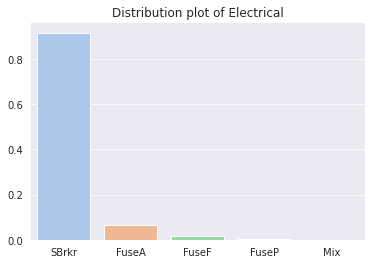

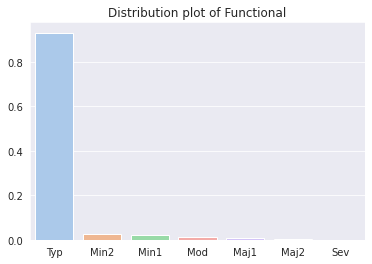

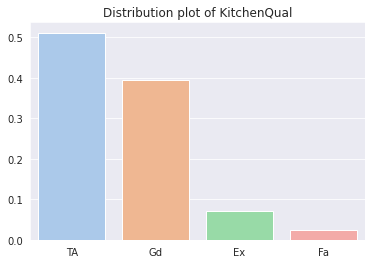

In [26]:
for metrics in ['Electrical','Functional','KitchenQual']:
    table = full[metrics].value_counts(normalize=True)
    sns.barplot(x=table.index,y=table.values)
    plt.title("Distribution plot of "+metrics)
    plt.show()
    print("\n")

These three metrics are safe to be filled with the mode values.

In [27]:
df['Electrical'].fillna('SBrkr',inplace=True)
test['Functional'].fillna('Typ',inplace=True)
test['KitchenQual'].fillna('TA',inplace=True)

In [28]:
full[full['GarageCars'].isnull()]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
2576,70,RM,50.0,9060,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,2Story,5,6,1923,1999,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,BrkTil,Gd,TA,No,ALQ,548.0,Unf,0.0,311.0,859.0,GasA,Ex,Y,SBrkr,942,886,0,1828,0.0,0.0,2,0,3,1,Gd,6,Typ,0,NaN,Detchd,NaN,NaN,NaN,NaN,NaN,NaN,Y,174,0,212,0,0,0,NaN,MnPrv,NaN,0,3,2007,WD,Alloca


Simililarly, this test data do not have a garage, filling GarageArea and GarageCars with 0.

In [29]:
test['GarageCars'].fillna(0,inplace=True)
test['GarageArea'].fillna(0,inplace=True)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
2489,20,RL,85.0,13770,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,Sawyer,Feedr,Norm,1Fam,1Story,5,6,1958,1998,Gable,CompShg,Plywood,Plywood,BrkFace,340.0,TA,TA,CBlock,TA,TA,Mn,Rec,190.0,BLQ,873.0,95.0,1158.0,GasA,TA,Y,SBrkr,1176,0,0,1176,1.0,0.0,1,0,3,1,TA,6,Typ,2,Gd,Attchd,1958.0,Unf,1.0,303.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,10,2007,NaN,Normal


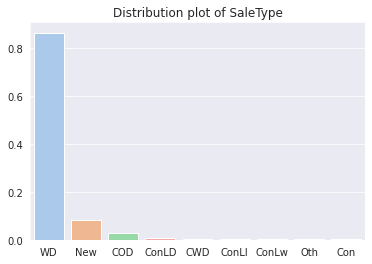

In [30]:
display(full[full['SaleType'].isnull()])
table = full['SaleType'].value_counts(normalize=True)
sns.barplot(x=table.index,y=table.values)
plt.title("Distribution plot of SaleType")
plt.show()

For the SaleType column, we will impute the missing data with the mode since the mode value is kinda high too.

In [31]:
test['SaleType'].fillna('WD',inplace=True)

It's now a good time to recheck all other remaining missing values.

In [32]:
print("Total null values:")
print(df.isna().sum().sum() + test.isna().sum().sum())
print("\nNull columns and counts in each dataset\n")
for col in df.columns:
    null = df[col].isnull().sum()
    test_null = test[col].isnull().sum()
    if null != 0 and test_null != 0:
        print(col,df[col].dtypes)
        print("Missing in train set:" +  str(null))
        print("Missing in test set:" + str(test_null))
        print("\n")
    elif null != 0:
        print(col,df[col].dtypes)
        print("Missing in train set:" +  str(null))
        print("\n")
    elif test_null !=0:
        print(col,test[col].dtypes)
        print("Missing in test set:" +  str(test_null))
        print("\n")
    

Total null values:
10281

Null columns and counts in each dataset

FireplaceQu object
Missing in train set:690
Missing in test set:730


GarageType object
Missing in train set:81
Missing in test set:76


GarageYrBlt float64
Missing in train set:81
Missing in test set:78


GarageFinish object
Missing in train set:81
Missing in test set:78


GarageQual object
Missing in train set:81
Missing in test set:78


GarageCond object
Missing in train set:81
Missing in test set:78


PoolQC object
Missing in train set:1452
Missing in test set:1456


Fence object
Missing in train set:1178
Missing in test set:1169


MiscFeature object
Missing in train set:1405
Missing in test set:1408




We do not have anything extra to infer these missing columns. Hence, we will treat them as "None" which is not having those items.

In [33]:
df['GarageYrBlt'].fillna(0,inplace=True)
test['GarageYrBlt'].fillna(0,inplace=True)
df.fillna("None", inplace=True)
test.fillna("None", inplace=True)

In [34]:
df.isnull().sum().sum() + test.isnull().sum().sum()

0

In [35]:
df.index = df.index - 1

In [36]:
df.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1450, 1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458, 1459],
           dtype='int64', name='Id', length=1459)

# ***Feature Engineering***


 mu = 180921.20 and sigma = 79415.29



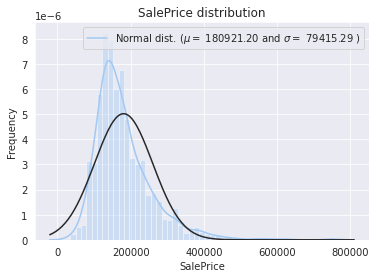

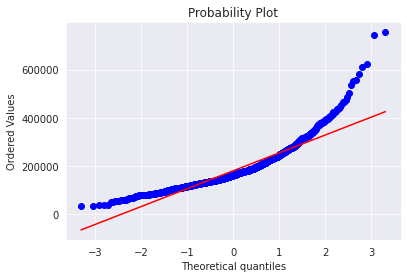

In [37]:
sns.distplot(y , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(y)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = probplot(y, plot=plt)
plt.show()

The target variable seems to be right skewed. We will have to transform it to be more normally distributed.

In [38]:
y = np.log(y)


 mu = 12.02 and sigma = 0.40



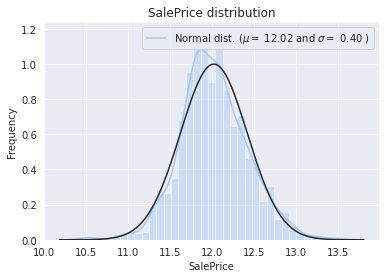

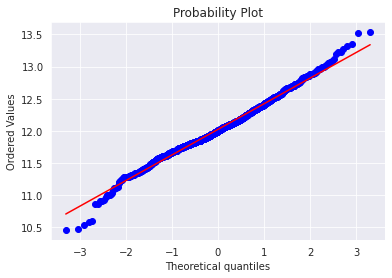

In [39]:
sns.distplot(y , fit=norm);
(mu, sigma) = norm.fit(y)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = probplot(y, plot=plt)
plt.show()

In [40]:
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
test['TotalSF'] = test['TotalBsmtSF'] + test['1stFlrSF'] + test['2ndFlrSF']

In [41]:
for table in [df,test]:
    table['MSSubClass'] = table['MSSubClass'].apply(str)
    table['YrSold'] = table['YrSold'].astype(str)
    table['MoSold'] = table['MoSold'].astype(str)

In [42]:
qual_dict = {'None': 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}
bsmt_fin_dict = {'None': 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6}

for table in [df,test]:
    table["ExterQual"] = table["ExterQual"].map(qual_dict)
    table["ExterCond"] = table["ExterCond"].map(qual_dict)
    table["BsmtQual"] = table["BsmtQual"].map(qual_dict)
    table["BsmtCond"] = table["BsmtCond"].map(qual_dict)
    table["PoolQC"] = table["PoolQC"].map(qual_dict)
    table["HeatingQC"] = table["HeatingQC"].map(qual_dict)
    table["KitchenQual"] = table["KitchenQual"].map(qual_dict)
    table["FireplaceQu"] = table["FireplaceQu"].map(qual_dict)
    table["GarageQual"] = table["GarageQual"].map(qual_dict)
    table["GarageCond"] = table["GarageCond"].map(qual_dict)

    table["BsmtExposure"] = table["BsmtExposure"].map(
        {'None': 0, "No": 1, "Mn": 2, "Av": 3, "Gd": 4}) 
    table["BsmtFinType1"] = table["BsmtFinType1"].map(bsmt_fin_dict)
    table["BsmtFinType2"] = table["BsmtFinType2"].map(bsmt_fin_dict)

    table["Functional"] = table["Functional"].map(
        {'None': 0, "Sal": 1, "Sev": 2, "Maj2": 3, "Maj1": 4, 
         "Mod": 5, "Min2": 6, "Min1": 7, "Typ": 8})

    table["GarageFinish"] = table["GarageFinish"].map(
        {'None': 0, "Unf": 1, "RFn": 2, "Fin": 3})

    table["Fence"] = table["Fence"].map(
        {'None': 0, "MnWw": 1, "GdWo": 2, "MnPrv": 3, "GdPrv": 4})
    
    table["CentralAir"] = table["CentralAir"].map(
        {'N': 0, "Y": 1})
    
    table["PavedDrive"] = table["PavedDrive"].map(
        {'N': 0, "P": 1, "Y": 2})

    
    table["Street"] = table["Street"].map(
        {'Grvl': 0, "Pave": 1})
    
    table["Alley"] = table["Alley"].map(
        {'None': 0, "Grvl": 1, "Pave": 2})
    
    table["LandSlope"] = table["LandSlope"].map(
        {'Gtl': 0, "Mod": 1, "Sev": 2})
    
    table["LotShape"] = table["LotShape"].map(
        {'Reg': 0, "IR1": 1, "IR2": 2, "IR3": 3})
    
modified_cols = ['ExterQual','ExterCond','BsmtQual','BsmtCond','HeatingQC','KitchenQual' \
                    ,'FireplaceQu','GarageQual','GarageCond','BsmtExposure','BsmtFinType1' \
                   ,'BsmtFinType2', 'Functional','GarageFinish','Fence','Street','Alley','LandSlope'\
                    ,'PavedDrive' ,'CentralAir','PoolQC','OverallQual','OverallCond','LotShape']

# Get list of categorical variables in holiday dataset
s = (df.dtypes == 'object')
object_cols = list(s[s].index)
object_cols = [x for x in object_cols if x not in modified_cols]


Summary statistics and graph for MSSubClass


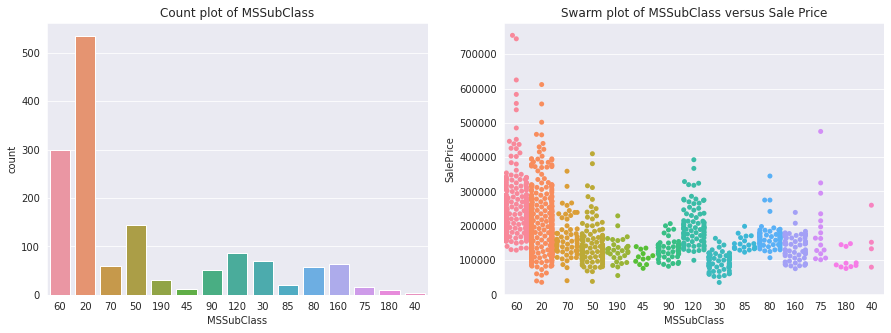

,count,mean,std,min,25%,50%,75%,max
MSSubClass,,,,,,,,
120,87.0,200779.080460,58221.490909,99500.0,158050.0,192000.0,232000.0,392500.0
160,63.0,138647.380952,34587.542266,75000.0,114000.0,146000.0,164850.0,239000.0
180,10.0,102300.000000,29474.282575,75500.0,81875.0,88500.0,128000.0,148000.0
190,30.0,129613.333333,35439.097670,55000.0,108875.0,128250.0,143750.0,228950.0
20,535.0,185314.016822,78828.821608,35311.0,132500.0,159500.0,220000.0,611657.0
30,69.0,95829.724638,24857.110083,34900.0,81000.0,99900.0,110500.0,163500.0
40,4.0,156125.000000,75747.799748,79500.0,119625.0,142500.0,179000.0,260000.0
45,12.0,108591.666667,20231.723889,76000.0,94125.0,107500.0,122250.0,139400.0
50,144.0,143302.972222,54851.983707,37900.0,114125.0,132000.0,159000.0,410000.0



Summary statistics and graph for MSZoning


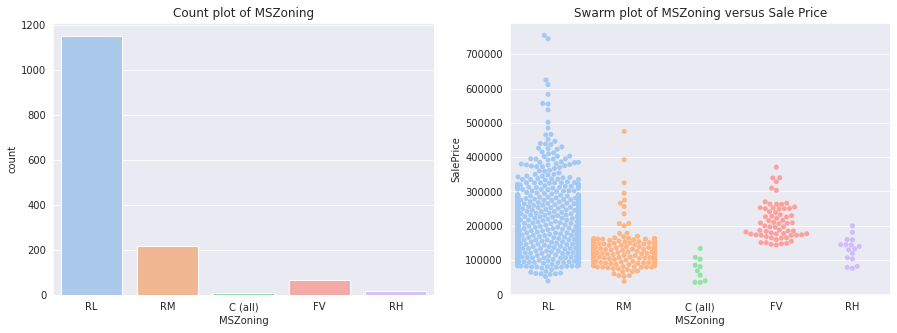

,count,mean,std,min,25%,50%,75%,max
MSZoning,,,,,,,,
C (all),10.0,74528.000000,33791.092031,34900.0,43998.25,74700.0,98332.0,133900.0
FV,65.0,214014.061538,52369.662067,144152.0,174000.00,205950.0,250000.0,370878.0
RH,16.0,131558.375000,35714.118435,76000.0,106150.00,136500.0,148608.5,200000.0
RL,1150.0,191051.520870,80786.047468,39300.0,137925.00,174000.0,224800.0,755000.0
RM,218.0,126316.830275,48521.689833,37900.0,100000.00,120500.0,140000.0,475000.0



Summary statistics and graph for LandContour


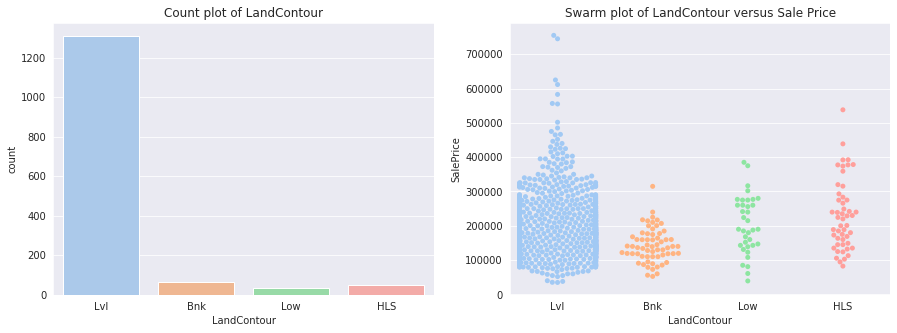

,count,mean,std,min,25%,50%,75%,max
LandContour,,,,,,,,
Bnk,63.0,143104.079365,49361.244074,52500.0,113000.0,139400.0,171250.00,315000.0
HLS,50.0,231533.940000,101790.139741,82500.0,151750.0,222250.0,281347.25,538000.0
Low,36.0,203661.111111,83935.353620,39300.0,143000.0,190000.0,263750.00,385000.0
Lvl,1310.0,180216.329771,78484.659858,34900.0,130000.0,162950.0,212000.00,755000.0



Summary statistics and graph for LotConfig


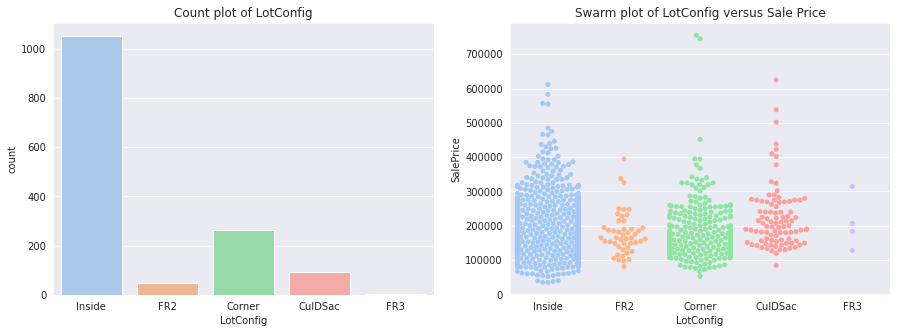

,count,mean,std,min,25%,50%,75%,max
LotConfig,,,,,,,,
Corner,263.0,181623.425856,84466.041222,52500.0,129250.0,160000.0,220000.0,755000.0
CulDSac,93.0,224783.161290,93183.683837,84000.0,157900.0,200624.0,269790.0,625000.0
FR2,47.0,177934.574468,62788.926829,81000.0,143500.0,165000.0,194500.0,394617.0
FR3,4.0,208475.000000,78379.222374,128000.0,169925.0,195450.0,234000.0,315000.0
Inside,1052.0,176938.047529,76426.805787,34900.0,128000.0,159697.5,207125.0,611657.0



Summary statistics and graph for Neighborhood


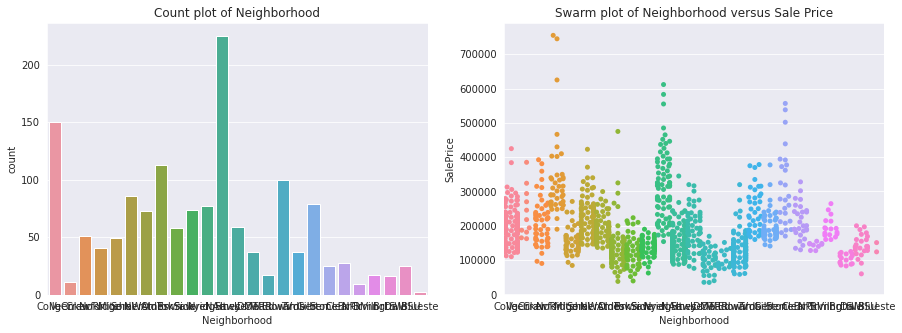

,count,mean,std,min,25%,50%,75%,max
Neighborhood,,,,,,,,
Blmngtn,17.0,194870.882353,30393.229219,159895.0,174000.00,191000.0,213490.0,264561.0
Blueste,2.0,137500.000000,19091.883092,124000.0,130750.00,137500.0,144250.0,151000.0
BrDale,16.0,104493.750000,14330.176493,83000.0,91000.00,106000.0,118000.0,125000.0
BrkSide,58.0,124834.051724,40348.689270,39300.0,100500.00,124300.0,141175.0,223500.0
ClearCr,28.0,212565.428571,50231.538993,130000.0,183750.00,200250.0,242225.0,328000.0
CollgCr,150.0,197965.773333,51403.666438,110000.0,152958.75,197200.0,225725.0,424870.0
Crawfor,51.0,210624.725490,68866.395472,90350.0,159250.00,200624.0,239000.0,392500.0
Edwards,100.0,128219.700000,43208.616459,58500.0,101500.00,121750.0,145225.0,320000.0
Gilbert,79.0,192854.506329,35986.779085,141000.0,174000.00,181000.0,197200.0,377500.0



Summary statistics and graph for Condition1


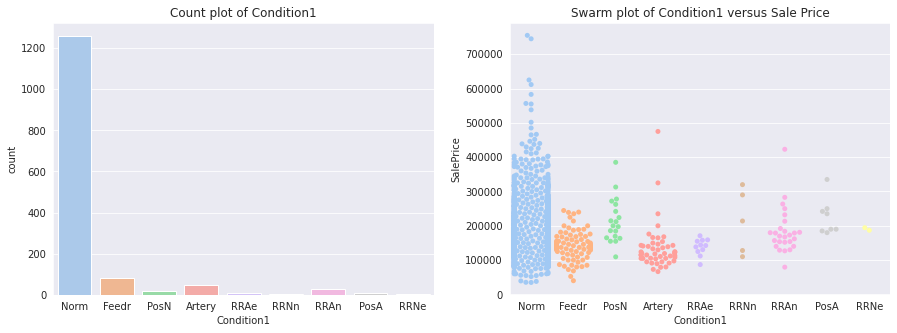

,count,mean,std,min,25%,50%,75%,max
Condition1,,,,,,,,
Artery,48.0,135091.666667,66226.660548,66500.0,105000.00,119550.0,143000.0,475000.0
Feedr,81.0,142475.481481,42157.290117,40000.0,121600.00,140000.0,167500.0,244600.0
Norm,1259.0,184532.819698,81278.461883,34900.0,131500.00,167000.0,219500.0,755000.0
PosA,8.0,225875.000000,52348.932313,180000.0,188750.00,212500.0,244000.0,335000.0
PosN,19.0,215184.210526,65256.536609,109500.0,167250.00,200000.0,252250.0,385000.0
RRAe,11.0,138400.000000,24030.813553,87000.0,127750.00,142500.0,156500.0,171000.0
RRAn,26.0,184396.615385,66177.922070,79500.0,152393.75,171495.0,190105.0,423000.0
RRNe,2.0,190750.000000,5303.300859,187000.0,188875.00,190750.0,192625.0,194500.0
RRNn,5.0,212400.000000,93823.238060,110000.0,128000.00,214000.0,290000.0,320000.0



Summary statistics and graph for Condition2


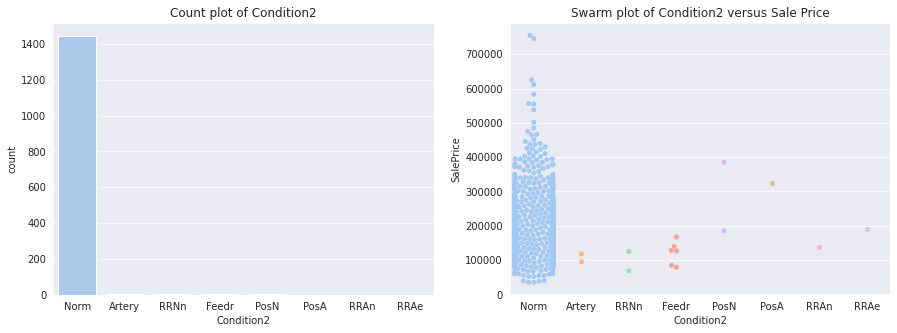

,count,mean,std,min,25%,50%,75%,max
Condition2,,,,,,,,
Artery,2.0,106500.000000,16263.455967,95000.0,100750.0,106500.0,112250.0,118000.0
Feedr,6.0,121166.666667,33544.994659,79500.0,95500.0,127500.0,137000.0,167500.0
Norm,1444.0,181199.647507,79356.889297,34900.0,130000.0,163500.0,214000.0,755000.0
PosA,1.0,325000.000000,NaN,325000.0,325000.0,325000.0,325000.0,325000.0
PosN,2.0,284875.000000,141598.132933,184750.0,234812.5,284875.0,334937.5,385000.0
RRAe,1.0,190000.000000,NaN,190000.0,190000.0,190000.0,190000.0,190000.0
RRAn,1.0,136905.000000,NaN,136905.0,136905.0,136905.0,136905.0,136905.0
RRNn,2.0,96750.000000,39951.533137,68500.0,82625.0,96750.0,110875.0,125000.0



Summary statistics and graph for BldgType


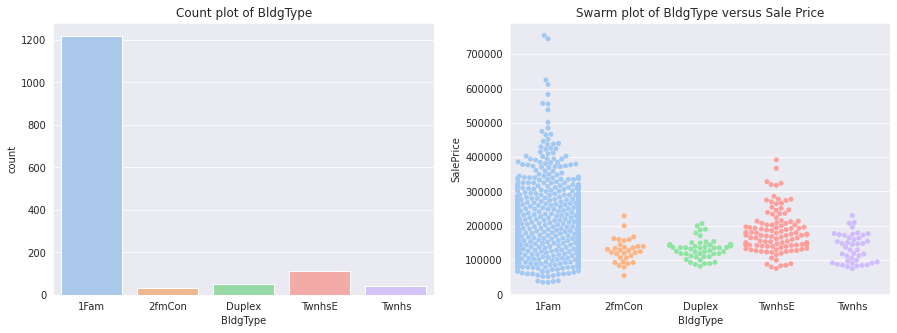

,count,mean,std,min,25%,50%,75%,max
BldgType,,,,,,,,
1Fam,1219.0,185803.400328,82670.848433,34900.0,131450.0,167900.0,222000.0,755000.0
2fmCon,31.0,128432.258065,35458.545158,55000.0,106875.0,127500.0,142500.0,228950.0
Duplex,52.0,133541.076923,27833.249197,82000.0,118375.0,135980.0,145000.0,206300.0
Twnhs,43.0,135911.627907,41013.222080,75000.0,95750.0,137500.0,168750.0,230000.0
TwnhsE,114.0,181959.342105,60626.108918,75500.0,143187.5,172200.0,207375.0,392500.0



Summary statistics and graph for HouseStyle


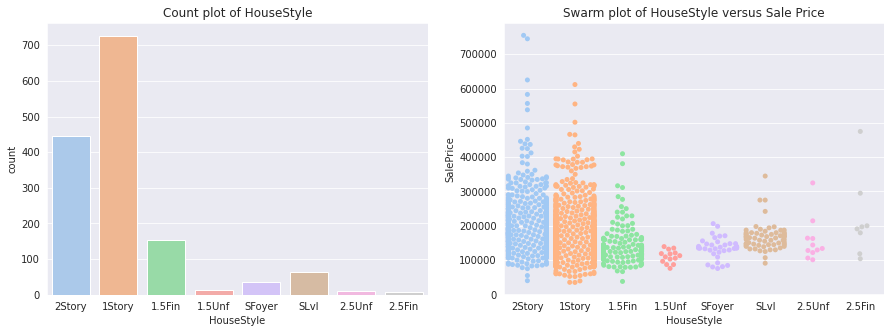

,count,mean,std,min,25%,50%,75%,max
HouseStyle,,,,,,,,
1.5Fin,154.0,143116.740260,54277.941119,37900.0,114625.0,132000.0,159325.5,410000.0
1.5Unf,14.0,110150.000000,19036.473090,76000.0,98175.0,111250.0,120500.0,139400.0
1Story,726.0,175985.477961,77055.715011,34900.0,127000.0,154750.0,209350.0,611657.0
2.5Fin,8.0,220000.000000,118211.976671,104000.0,164250.0,194000.0,223750.0,475000.0
2.5Unf,11.0,157354.545455,63934.128032,101000.0,125000.0,133900.0,163500.0,325000.0
2Story,445.0,210051.764045,87339.213570,40000.0,159500.0,190000.0,240000.0,755000.0
SFoyer,37.0,135074.486486,30480.898192,75500.0,127500.0,135960.0,148000.0,206300.0
SLvl,64.0,167159.687500,38429.506974,91000.0,145000.0,164750.0,178475.0,345000.0



Summary statistics and graph for RoofStyle


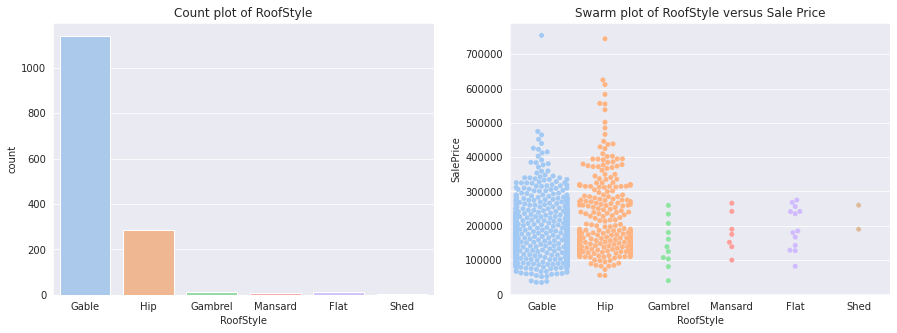

,count,mean,std,min,25%,50%,75%,max
RoofStyle,,,,,,,,
Flat,13.0,194690.000000,62522.963515,82000.0,143000.0,185000.0,242000.00,274970.0
Gable,1140.0,171513.766667,66352.702094,34900.0,128000.0,160000.0,202541.25,755000.0
Gambrel,11.0,148909.090909,67013.527807,40000.0,105500.0,139000.0,193750.00,259500.0
Hip,286.0,218876.933566,111549.603563,55000.0,139675.0,176500.0,277875.00,745000.0
Mansard,7.0,180568.428571,58057.624627,100000.0,145500.0,175000.0,216000.00,265979.0
Shed,2.0,225000.000000,49497.474683,190000.0,207500.0,225000.0,242500.00,260000.0



Summary statistics and graph for RoofMatl


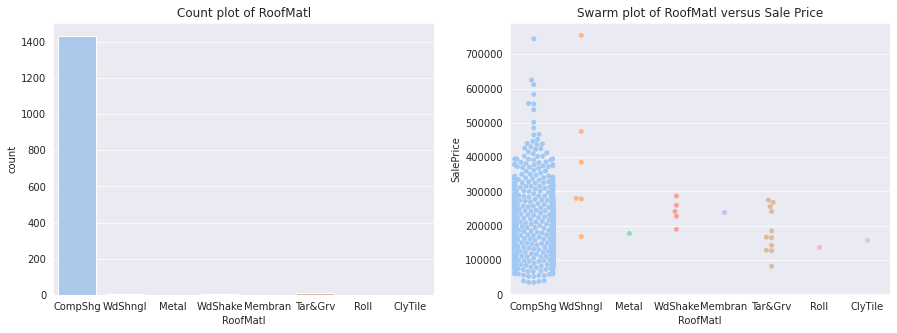

,count,mean,std,min,25%,50%,75%,max
RoofMatl,,,,,,,,
ClyTile,1.0,160000.000000,NaN,160000.0,160000.0,160000.0,160000.0,160000.0
CompShg,1433.0,179833.200279,77741.478737,34900.0,129900.0,162000.0,213000.0,745000.0
Membran,1.0,241500.000000,NaN,241500.0,241500.0,241500.0,241500.0,241500.0
Metal,1.0,180000.000000,NaN,180000.0,180000.0,180000.0,180000.0,180000.0
Roll,1.0,137000.000000,NaN,137000.0,137000.0,137000.0,137000.0,137000.0
Tar&Grv,11.0,185406.363636,65430.141720,82000.0,136000.0,167000.0,249000.0,274970.0
WdShake,5.0,241400.000000,36218.779659,190000.0,228000.0,242000.0,260000.0,287000.0
WdShngl,6.0,390250.000000,206969.019421,168500.0,278500.0,332500.0,452500.0,755000.0



Summary statistics and graph for Exterior1st


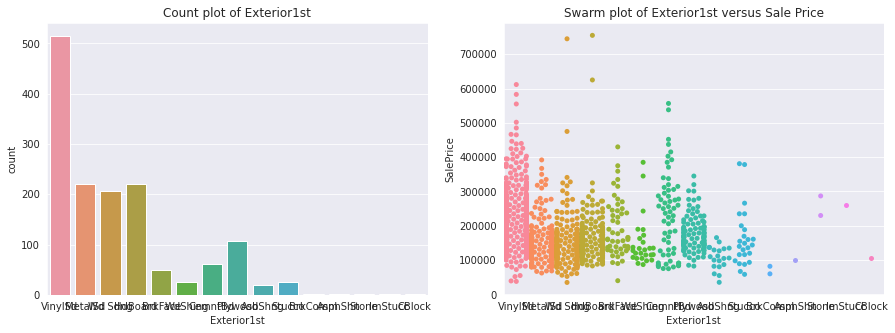

,count,mean,std,min,25%,50%,75%,max
Exterior1st,,,,,,,,
AsbShng,20.0,107385.550000,33756.480660,35311.0,85750.0,108000.0,133500.0,165500.0
AsphShn,1.0,100000.000000,NaN,100000.0,100000.0,100000.0,100000.0,100000.0
BrkComm,2.0,71000.000000,15556.349186,60000.0,65500.0,71000.0,76500.0,82000.0
BrkFace,50.0,194573.000000,82841.914370,40000.0,134525.0,165750.0,245125.0,430000.0
CBlock,1.0,105000.000000,NaN,105000.0,105000.0,105000.0,105000.0,105000.0
CemntBd,61.0,231690.655738,120575.621318,75000.0,119500.0,236500.0,303477.0,556581.0
HdBoard,221.0,163193.185520,66433.759981,83000.0,129500.0,149900.0,179900.0,755000.0
ImStucc,1.0,262000.000000,NaN,262000.0,262000.0,262000.0,262000.0,262000.0
MetalSd,220.0,149422.177273,54776.408990,62383.0,117750.0,139000.0,164775.0,392000.0



Summary statistics and graph for Exterior2nd


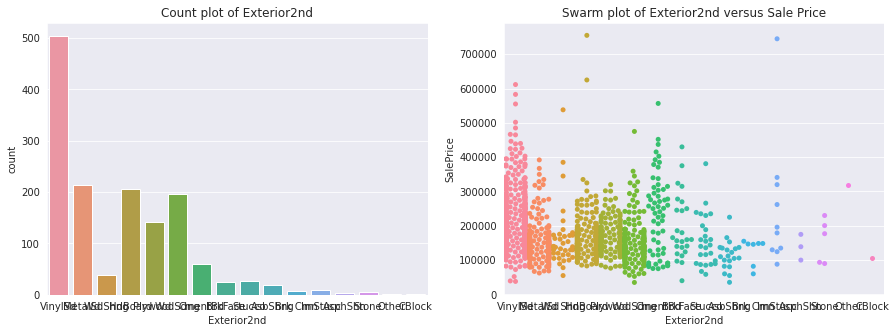

,count,mean,std,min,25%,50%,75%,max
Exterior2nd,,,,,,,,
AsbShng,20.0,114060.550000,42315.043608,35311.0,94000.0,111000.0,135500.00,225000.0
AsphShn,3.0,138000.000000,37509.998667,100000.0,119500.0,139000.0,157000.00,175000.0
Brk Cmn,7.0,126714.285714,38693.084161,60000.0,114000.0,147000.0,148500.00,155000.0
BrkFace,25.0,195818.000000,95097.551756,40000.0,137000.0,160000.0,250000.00,430000.0
CBlock,1.0,105000.000000,NaN,105000.0,105000.0,105000.0,105000.00,105000.0
CmentBd,60.0,230093.833333,116140.396221,75000.0,118375.0,238750.0,304082.75,556581.0
HdBoard,206.0,167807.980583,70199.997644,83000.0,130250.0,156000.0,183250.00,755000.0
ImStucc,10.0,252070.000000,193176.672447,88000.0,131250.0,187600.0,305500.00,745000.0
MetalSd,214.0,149803.172897,55078.595310,62383.0,118625.0,138750.0,164525.00,392000.0



Summary statistics and graph for MasVnrType


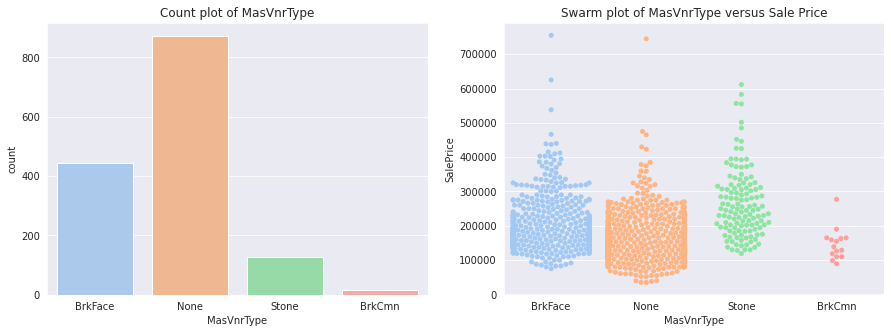

,count,mean,std,min,25%,50%,75%,max
MasVnrType,,,,,,,,
BrkCmn,15.0,146318.066667,46187.583632,89471.0,114250.0,139000.0,163950.0,277000.0
BrkFace,444.0,204843.204955,81243.067841,75000.0,149450.0,181450.0,236250.0,755000.0
None,872.0,156958.243119,61491.688969,34900.0,119000.0,143125.0,184025.0,745000.0
Stone,128.0,265583.625000,99940.156577,119000.0,194650.0,246839.0,312779.0,611657.0



Summary statistics and graph for Foundation


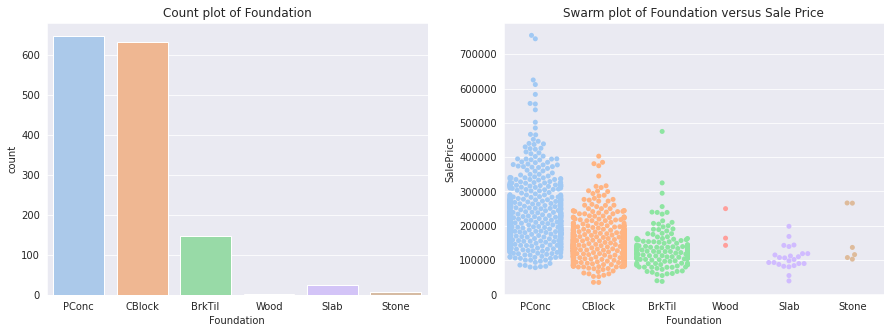

,count,mean,std,min,25%,50%,75%,max
Foundation,,,,,,,,
BrkTil,146.0,132291.075342,54592.393032,37900.0,102400.0,125250.0,151250.00,475000.0
CBlock,633.0,149825.154818,48330.752098,34900.0,122000.0,142000.0,168000.00,402861.0
PConc,647.0,225230.442040,86865.977283,78000.0,173000.0,205000.0,262140.00,755000.0
Slab,24.0,107365.625000,34213.980939,39300.0,89375.0,104150.0,118884.50,198500.0
Stone,6.0,165959.166667,78557.704413,102776.0,109625.0,126500.0,233734.25,266500.0
Wood,3.0,185666.666667,56695.090910,143000.0,153500.0,164000.0,207000.00,250000.0



Summary statistics and graph for Heating


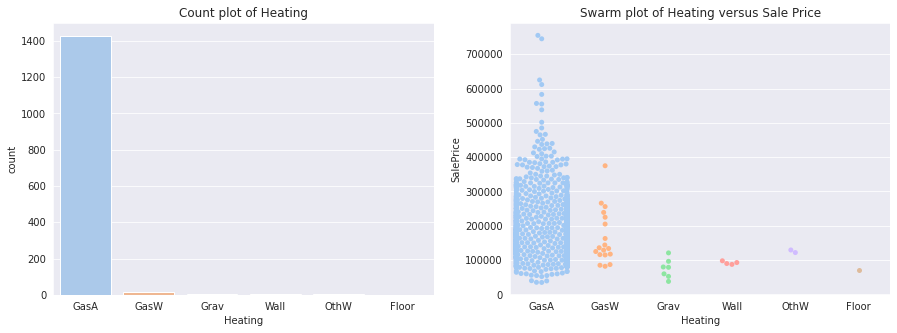

,count,mean,std,min,25%,50%,75%,max
Heating,,,,,,,,
Floor,1.0,72500.000000,NaN,72500.0,72500.0,72500.0,72500.0,72500.0
GasA,1427.0,182052.394534,79281.888915,34900.0,130500.0,164500.0,214250.0,755000.0
GasW,18.0,166632.166667,78547.575324,82000.0,116375.0,134950.0,220000.0,375000.0
Grav,7.0,75271.428571,28066.570524,37900.0,56250.0,79000.0,88250.0,121000.0
OthW,2.0,125750.000000,5303.300859,122000.0,123875.0,125750.0,127625.0,129500.0
Wall,4.0,92100.000000,4509.988914,87500.0,89375.0,91450.0,94175.0,98000.0



Summary statistics and graph for Electrical


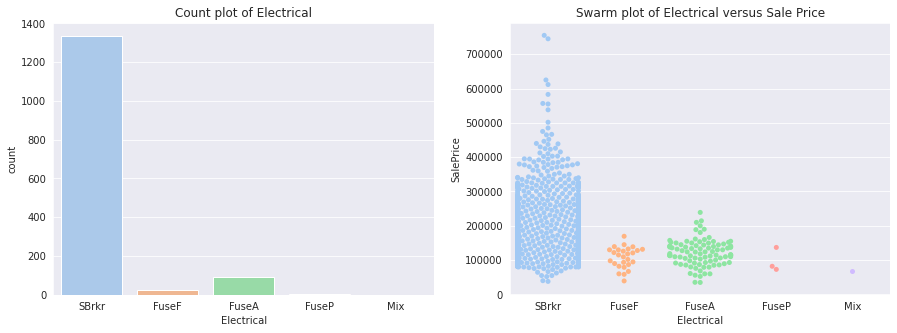

,count,mean,std,min,25%,50%,75%,max
Electrical,,,,,,,,
FuseA,93.0,122032.344086,37680.566832,34900.0,98000.0,119000.0,144000.0,239000.0
FuseF,27.0,107675.444444,30636.507376,39300.0,88500.0,115000.0,129950.0,169500.0
FuseP,3.0,97333.333333,34645.827070,73000.0,77500.0,82000.0,109500.0,137000.0
Mix,1.0,67000.000000,NaN,67000.0,67000.0,67000.0,67000.0,67000.0
SBrkr,1335.0,186810.637453,79828.273697,37900.0,134650.0,170000.0,220500.0,755000.0



Summary statistics and graph for GarageType


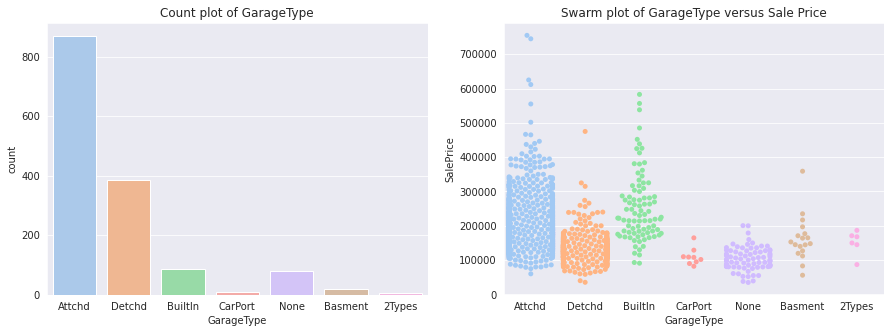

,count,mean,std,min,25%,50%,75%,max
GarageType,,,,,,,,
2Types,6.0,151283.333333,34917.068415,87000.0,146250.0,159000.0,170250.00,186700.0
Attchd,870.0,202892.656322,77146.621778,60000.0,150000.0,185000.0,235000.00,755000.0
Basment,18.0,161852.388889,65570.265116,55993.0,130250.0,150500.0,175500.00,359100.0
BuiltIn,88.0,254751.738636,102230.854394,91000.0,180750.0,227500.0,300719.25,582933.0
CarPort,9.0,109962.111111,24638.183681,82000.0,95000.0,108000.0,110000.00,164900.0
Detchd,387.0,134091.162791,41391.549953,35311.0,110000.0,129500.0,147700.00,475000.0
None,81.0,103317.283951,32815.023389,34900.0,82500.0,100000.0,124000.00,200500.0



Summary statistics and graph for MiscFeature


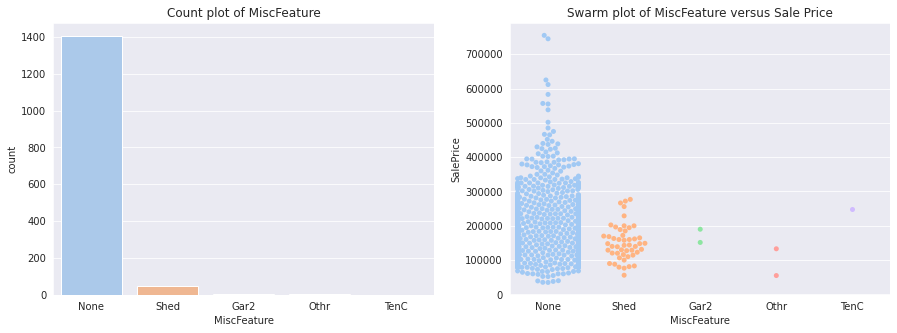

,count,mean,std,min,25%,50%,75%,max
MiscFeature,,,,,,,,
Gar2,2.0,170750.000000,27223.611076,151500.0,161125.0,170750.0,180375.0,190000.0
None,1405.0,182078.116014,80103.823529,34900.0,130000.0,164500.0,215000.0,755000.0
Othr,2.0,94000.000000,55154.328933,55000.0,74500.0,94000.0,113500.0,133000.0
Shed,49.0,151187.612245,51642.728056,55993.0,120000.0,144000.0,172000.0,277000.0
TenC,1.0,250000.000000,NaN,250000.0,250000.0,250000.0,250000.0,250000.0



Summary statistics and graph for MoSold


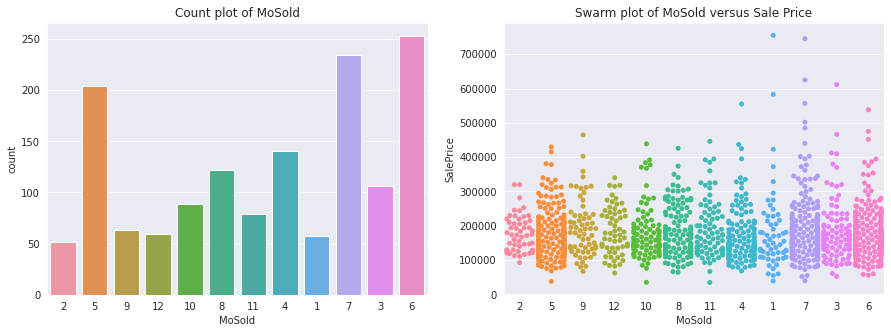

,count,mean,std,min,25%,50%,75%,max
MoSold,,,,,,,,
1,57.0,184059.000000,122304.623904,39300.0,118000.0,154300.0,216000.0,755000.0
10,89.0,179563.977528,75736.008303,35311.0,135500.0,159000.0,202500.0,438780.0
11,79.0,192210.911392,83517.711202,34900.0,130000.0,173000.0,238500.0,446261.0
12,59.0,186518.966102,69495.155055,62383.0,135480.0,178000.0,239500.0,340000.0
2,52.0,177882.000000,52960.863135,93000.0,129175.0,173250.0,211225.0,320000.0
3,106.0,183253.924528,86488.445599,52500.0,133725.0,165250.0,200593.0,611657.0
4,141.0,171503.262411,77147.323106,68400.0,124000.0,147000.0,202900.0,555000.0
5,204.0,172307.269608,68614.545198,37900.0,127750.0,154000.0,204812.5,430000.0
6,253.0,177395.735178,69453.085881,55993.0,136000.0,163000.0,204000.0,538000.0



Summary statistics and graph for YrSold


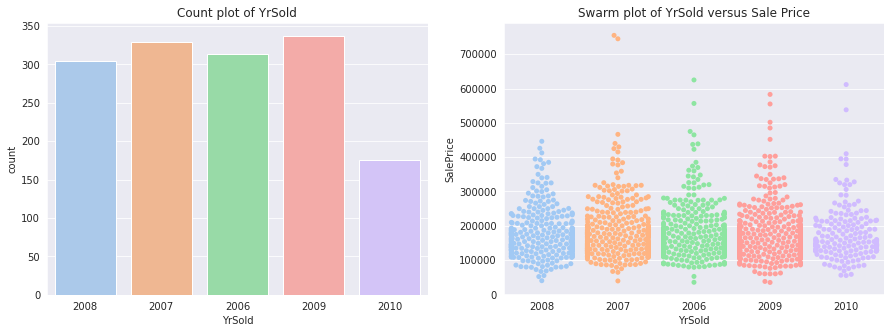

,count,mean,std,min,25%,50%,75%,max
YrSold,,,,,,,,
2006,314.0,182549.458599,79426.838855,35311.0,131375.0,163995.0,218782.5,625000.0
2007,329.0,186063.151976,85768.171410,39300.0,129900.0,167000.0,219500.0,755000.0
2008,304.0,177360.838816,69735.610685,40000.0,131250.0,164000.0,207000.0,446261.0
2009,337.0,179556.531157,80967.098654,34900.0,125000.0,162000.0,213000.0,582933.0
2010,175.0,177393.674286,80451.280085,55000.0,128100.0,155000.0,213250.0,611657.0



Summary statistics and graph for SaleType


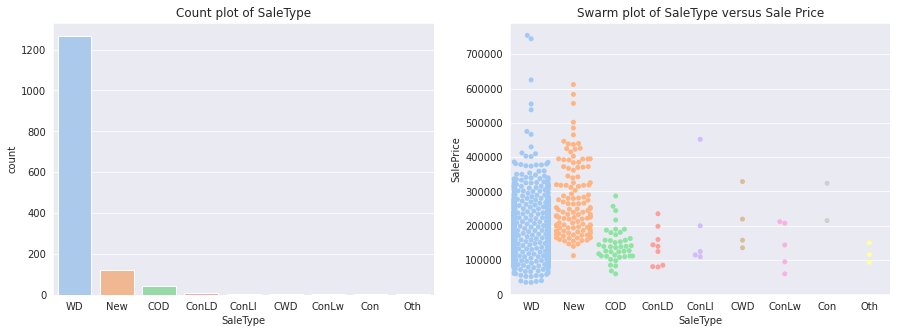

,count,mean,std,min,25%,50%,75%,max
SaleType,,,,,,,,
COD,42.0,144127.380952,47658.227097,60000.0,112000.00,139000.0,161750.00,287000.0
CWD,4.0,210600.000000,86421.486526,136000.0,152500.00,188750.0,246850.00,328900.0
Con,2.0,269600.000000,76933.217793,215200.0,242400.00,269600.0,296800.00,324000.0
ConLD,9.0,138780.888889,53876.560647,79900.0,85000.00,140000.0,160000.00,235128.0
ConLI,5.0,200390.000000,145282.519595,110000.0,115000.00,125000.0,200000.00,451950.0
ConLw,5.0,143700.000000,67291.901444,60000.0,95000.00,144000.0,207500.00,212000.0
New,122.0,274945.418033,103239.582158,113000.0,194050.25,247453.0,341919.75,611657.0
Oth,3.0,119850.000000,28441.035495,93500.0,104775.00,116050.0,133025.00,150000.0
WD,1267.0,173401.836622,71129.686245,34900.0,128925.00,158000.0,202950.00,755000.0



Summary statistics and graph for SaleCondition


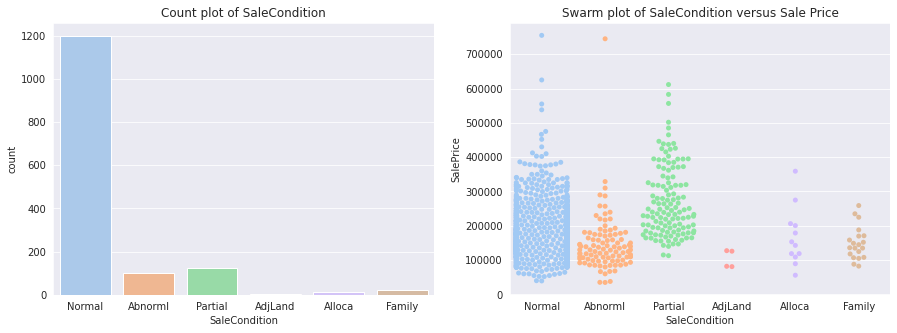

,count,mean,std,min,25%,50%,75%,max
SaleCondition,,,,,,,,
Abnorml,100.0,146616.890000,83208.330520,34900.0,103694.00,130000.0,172875.0,745000.0
AdjLand,4.0,104125.000000,26135.464411,81000.0,81750.00,104000.0,126375.0,127500.0
Alloca,12.0,167377.416667,84460.527502,55993.0,116383.25,148145.0,202043.0,359100.0
Family,20.0,149600.000000,47820.002421,82500.0,115500.00,140500.0,170250.0,259000.0
Normal,1198.0,175202.219533,69713.636280,39300.0,130000.00,160000.0,205000.0,755000.0
Partial,125.0,272291.752000,103696.404119,113000.0,193879.00,244600.0,339750.0,611657.0


In [43]:
full = pd.merge(left = df, right = y , left_index= True, right_index = True)
full['SalePrice'] = np.exp(full['SalePrice'])

for col in object_cols:
    if len(full[col].unique())> 1:
        print("\nSummary statistics and graph for "+ col)
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
        sns.countplot(data = full, x=col, ax= ax[0])
        ax[0].title.set_text("Count plot of " + col)
        sns.swarmplot(data=full,x=col,y='SalePrice', ax= ax[1])
        ax[1].title.set_text("Swarm plot of " + col +" versus Sale Price")
        plt.show()
        display(full.groupby(col)['SalePrice'].describe())

In [44]:
cond_1_keep = ['Norm','Feedr','Artery']
roof_style_keep = ['Gable','Hip']
foundation_keep = ['PConc','CBlock','BrkTil']
garage_keep = ['Attchd','Detchd','BuiltIn']
sale_keep = ['WD','New','COD']
sale_cond_keep = ['Normal','Abnorml','Partial']
peak_months = ['5','6','7']
lot_config_keep = ['Inside','Corner','CulDSac']
unfinished_style = ['1.5Unf','2.5Unf']
exter_remove = ['AsphShn','BrkComm','CBlock','ImStucc','Stone']
for table in [df,test]:
    table.loc[table['LandContour']!='Lvl','LandContour'] = 0
    table.loc[table['LandContour']!=0,'LandContour'] = 1
    
    table.loc[~table['Condition1'].isin(cond_1_keep),'Condition1'] = "Others"
    table.loc[table['Condition2']!="Norm",'Condition2'] = 0
    table.loc[table['Condition2']!= 0,'Condition2'] = 1
    
    table.loc[~table['RoofStyle'].isin(roof_style_keep),'RoofStyle'] = "Others"
    table.loc[table['RoofMatl']!='CompShg','RoofMatl'] = 0
    table.loc[table['RoofMatl']!=0,'RoofMatl'] = 1
    
    table.loc[~table['Foundation'].isin(foundation_keep),'Foundation'] = "Others"
    table.loc[table['Heating']!='GasA','Heating'] = 0
    table.loc[table['Heating']=='GasA','Heating'] = 1
    table.loc[table['Electrical']!='SBrkr','Electrical'] = 0
    table.loc[table['Electrical']!=0,'Electrical'] = 1
    
    table.loc[~table['GarageType'].isin(garage_keep),'GarageType'] = "Others"
    
    table.loc[~table['SaleType'].isin(sale_keep),'SaleType'] = "Others"
    table.loc[~table['SaleCondition'].isin(sale_cond_keep),'SaleCondition'] = "Others"
    table.loc[~table['SaleCondition'].isin(sale_cond_keep),'SaleCondition'] = "Others"
    
    table.loc[table['Exterior1st'].isin(exter_remove),'Exterior1st'] = "Others"
    table.loc[table['Exterior2nd'].isin(exter_remove),'Exterior2nd'] = "Others"
    
    table.loc[table['MoSold'].isin(peak_months),'PeakMonths'] = 1
    table.loc[table['PeakMonths']!=1,'PeakMonths'] = 0
    
    table.loc[~table['LotConfig'].isin(lot_config_keep),'LotConfig'] = "Others"
    
    table.loc[~table['HouseStyle'].isin(unfinished_style),'Unfinished'] = 1
    table.loc[table['Unfinished']!= 1 ,'Unfinished'] = 0
    table.loc[table['HouseStyle'].isin(['SFoyer','SLvl']),'IsSplit'] = 1
    table.loc[table['IsSplit']!= 1 ,'IsSplit'] = 0   
    table["HouseStyle"] = table["HouseStyle"].map(
        {'SFoyer': 0, "SLvl": 0, "1Story": 1, "1.5Fin": 2, "1.5Unf": 2, "2Story": 3, "2.5Fin": 4, "2.5Unf": 4})
    
    table.drop('Utilities', axis = 1 , inplace = True)

    
modified_cols_round_2 = ['HouseStyle','LandContour','Condition2','RoofMatl','Heating','Electrical','Utilities']
object_cols = [x for x in object_cols if x not in modified_cols_round_2]

In [45]:
neighborhood = full.groupby(['Neighborhood'])['SalePrice'].describe()
display(neighborhood.head())

,count,mean,std,min,25%,50%,75%,max
Neighborhood,,,,,,,,
Blmngtn,17.0,194870.882353,30393.229219,159895.0,174000.0,191000.0,213490.0,264561.0
Blueste,2.0,137500.000000,19091.883092,124000.0,130750.0,137500.0,144250.0,151000.0
BrDale,16.0,104493.750000,14330.176493,83000.0,91000.0,106000.0,118000.0,125000.0
BrkSide,58.0,124834.051724,40348.689270,39300.0,100500.0,124300.0,141175.0,223500.0
ClearCr,28.0,212565.428571,50231.538993,130000.0,183750.0,200250.0,242225.0,328000.0


In [46]:
neighborhood_cluster = KMeans(n_clusters=5, random_state = 927)
neighborhood_cluster.fit(neighborhood)

KMeans(n_clusters=5, random_state=927)

Cluster 0
['Blmngtn' 'Edwards' 'Mitchel' 'NAmes' 'NWAmes' 'SawyerW']
Cluster 1
['NoRidge' 'NridgHt' 'StoneBr']
Cluster 2
['ClearCr' 'CollgCr' 'Crawfor' 'Gilbert' 'Somerst' 'Timber' 'Veenker']
Cluster 3
['Blueste' 'BrDale' 'BrkSide' 'IDOTRR' 'MeadowV' 'NPkVill' 'SWISU'
 'Sawyer']
Cluster 4
['OldTown']


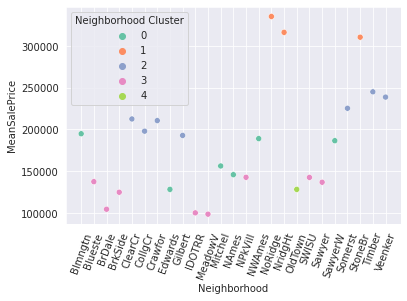

In [47]:
neigh_cluster_table = pd.DataFrame(zip(list(neighborhood.index),list(neighborhood.loc[:,'mean']),list(neighborhood_cluster.labels_)),columns = ['Neighborhood','MeanSalePrice','Neighborhood Cluster'])
for i  in range(len(neigh_cluster_table.groupby('Neighborhood Cluster')['Neighborhood'].unique())):
    print("Cluster " + str(i))
    print(neigh_cluster_table.groupby('Neighborhood Cluster')['Neighborhood'].unique()[i])
sns.scatterplot(data = neigh_cluster_table, x='Neighborhood',y = 'MeanSalePrice', hue='Neighborhood Cluster',palette=sns.color_palette("Set2",5))
plt.xticks(rotation=70)
plt.show()

In [48]:
subclass = full.groupby(['MSSubClass'])['SalePrice'].describe()
display(subclass.head())

,count,mean,std,min,25%,50%,75%,max
MSSubClass,,,,,,,,
120,87.0,200779.080460,58221.490909,99500.0,158050.0,192000.0,232000.0,392500.0
160,63.0,138647.380952,34587.542266,75000.0,114000.0,146000.0,164850.0,239000.0
180,10.0,102300.000000,29474.282575,75500.0,81875.0,88500.0,128000.0,148000.0
190,30.0,129613.333333,35439.097670,55000.0,108875.0,128250.0,143750.0,228950.0
20,535.0,185314.016822,78828.821608,35311.0,132500.0,159500.0,220000.0,611657.0


In [49]:
subclass_cluster = KMeans(n_clusters=4, random_state = 927)
subclass_cluster.fit(subclass)

KMeans(n_clusters=4, random_state=927)

Cluster 0
['180' '30' '45']
Cluster 1
['120' '50' '70' '75' '80']
Cluster 2
['20' '60']
Cluster 3
['160' '190' '40' '85' '90']


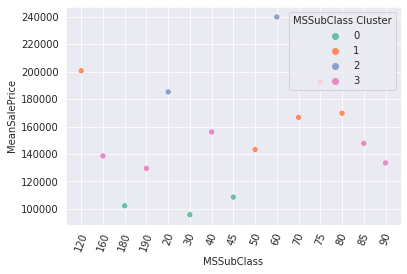

In [50]:
mssub_cluster_table = pd.DataFrame(zip(list(subclass.index),list(subclass.loc[:,'mean']),list(subclass_cluster.labels_)),columns = ['MSSubClass','MeanSalePrice','MSSubClass Cluster'])
for i  in range(len(mssub_cluster_table.groupby('MSSubClass Cluster')['MSSubClass'].unique())):
    print("Cluster " + str(i))
    print(mssub_cluster_table.groupby('MSSubClass Cluster')['MSSubClass'].unique()[i])
sns.scatterplot(data = mssub_cluster_table, x='MSSubClass',y = 'MeanSalePrice', hue='MSSubClass Cluster',palette=sns.color_palette("Set2",4))
plt.xticks(rotation=70)
plt.show()

In [51]:
mssub_cluster_table.drop('MeanSalePrice', axis = 1 ,inplace = True)
neigh_cluster_table.drop('MeanSalePrice', axis = 1, inplace = True)

In [52]:
df = pd.merge(left = df.reset_index(), right = mssub_cluster_table, how='left', on ='MSSubClass').set_index('Id')
df = pd.merge(left = df.reset_index(), right = neigh_cluster_table, how='left', on ='Neighborhood').set_index('Id')
df.drop('MSSubClass', axis = 1 ,inplace = True)
df.drop('Neighborhood', axis = 1 ,inplace = True)

In [53]:
test = pd.merge(left = test.reset_index(), right = mssub_cluster_table, how='left', on ='MSSubClass').set_index('Id')
test = pd.merge(left = test.reset_index(), right = neigh_cluster_table, how='left', on ='Neighborhood').set_index('Id')
test.drop('MSSubClass', axis = 1 ,inplace = True)
test.drop('Neighborhood', axis = 1 ,inplace = True)

In [54]:
modified_cols.append('MSSubClass')
modified_cols.append('Neighborhood')

In [55]:
object_cols.append('MSSubClass Cluster')
object_cols.append('Neighborhood Cluster')
object_cols.remove('MSSubClass')
object_cols.remove('Neighborhood')

In [56]:
# One Hot Encoding for Other Columns
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols = pd.DataFrame(OH_encoder.fit_transform(df[object_cols]))
OH_cols.index = df.index
OH_cols.columns = OH_encoder.get_feature_names(object_cols)
df = df.drop(object_cols, axis=1)
df = pd.concat([df, OH_cols], axis=1)

OH_cols = pd.DataFrame(OH_encoder.transform(test[object_cols]))
OH_cols.index = test.index
OH_cols.columns = OH_encoder.get_feature_names(object_cols)
test = test.drop(object_cols, axis=1)
test = pd.concat([test, OH_cols], axis=1)

In [57]:
skewed = df[df.columns[~df.columns.isin(list(OH_cols.columns) + modified_cols + object_cols)]].apply(lambda x: skew(x.dropna().astype(float)))
skewed = skewed[skewed > 0.5]
skewed = skewed.index

df[skewed] = np.log1p(df[skewed])
test[skewed] = np.log1p(test[skewed])

In [58]:
for col in df[df.columns]:
    if col not in (list(OH_cols.columns) + modified_cols + object_cols):
        scaler = RobustScaler()
        df[col] = scaler.fit_transform(df[[col]])
        test[col] = scaler.transform(test[[col]])

In [59]:
full = pd.merge(left = df, right = y , left_index= True, right_index = True)
mi = mutual_info_regression(X = full.drop('SalePrice', axis = 1), y = full['SalePrice'])
mi_df = pd.DataFrame(list(zip(full.columns,mi)), columns =['Feature','Mutual Info'])
mi_df = mi_df.sort_values('Mutual Info',ascending=False)

In [60]:
low_mi_df = mi_df[abs(mi_df['Mutual Info']) == 0]
filter_feature = sorted(list(low_mi_df['Feature']))
print("Number of low correlated features dropped: " + str(len(filter_feature)))
df = df.drop(filter_feature,axis=1)
test = test.drop(filter_feature,axis=1)

Number of low correlated features dropped: 25


In [61]:
top_mi_list = list(mi_df.head(20)['Feature'])
top_mi_subset = df[top_mi_list]
index_copy = top_mi_subset.index

poly = PolynomialFeatures(2, interaction_only=True)
poly_features = pd.DataFrame(poly.fit_transform(top_mi_subset),columns=poly.get_feature_names_out(top_mi_list))
poly_features = poly_features.iloc[:,len(top_mi_list) + 1:]
poly_features.set_index(index_copy, inplace = True)
poly_and_price = pd.concat([y,poly_features],axis=1).dropna()
top_20_poly = abs(poly_and_price.corr()['SalePrice']).sort_values(ascending=False)[1:21]

In [62]:
df = pd.concat([df,poly_features[top_20_poly.index]],axis=1)

In [63]:
top_mi_subset = test[top_mi_list]
index_copy = top_mi_subset.index
poly_features = pd.DataFrame(poly.transform(top_mi_subset),columns=poly.get_feature_names_out(top_mi_list))
poly_features = poly_features.iloc[:,len(top_mi_list) + 1:]
poly_features.set_index(index_copy, inplace = True)
test = pd.concat([test,poly_features[top_20_poly.index]],axis=1)

In [64]:
full = pd.merge(left = df, right = y , left_index= True, right_index = True)
train_y = full['SalePrice']
train_X = full.drop(['SalePrice'],axis=1)

In [65]:
start = time.time()
print("Recording Modelling Time")

Recording Modelling Time


In [66]:
ridgemodel = Ridge(alpha=26)
ridgemodel.fit(train_X,train_y)

Ridge(alpha=26)

In [67]:
xgbmodel = XGBRegressor(alpha= 3, colsample_bytree=0.5, reg_lambda=3, learning_rate= 0.01, max_depth=3, n_estimators=10000, subsample=0.65)
xgbmodel.fit(train_X,train_y)

XGBRegressor(alpha=3, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=10000, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=3,
             reg_lambda=3, scale_pos_weight=1, subsample=0.65,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [68]:
svrmodel = SVR(C=8, epsilon=0.00005, gamma=0.0008)
svrmodel.fit(train_X,train_y)

SVR(C=8, epsilon=5e-05, gamma=0.0008)

In [69]:
hubermodel = HuberRegressor(alpha=30,epsilon=3,fit_intercept=True,max_iter=2000)
hubermodel.fit(train_X,train_y)

HuberRegressor(alpha=30, epsilon=3, max_iter=2000)

In [70]:
cbmodel = cb.CatBoostRegressor(loss_function='RMSE',colsample_bylevel=0.3, depth=2, l2_leaf_reg=20, learning_rate=0.005, n_estimators=15000, subsample=0.3,verbose=False)
cbmodel.fit(train_X, train_y)

In [71]:
stackmodel = StackingCVRegressor(regressors=(ridgemodel, xgbmodel, svrmodel, hubermodel, cbmodel),
                                meta_regressor=cbmodel,
                                use_features_in_secondary=True)
stackmodel.fit(np.array(train_X), np.array(train_y))

StackingCVRegressor(meta_regressor=<catboost.core.CatBoostRegressor object at 0x7f6f4fb9ccd0>,
                    regressors=(Ridge(alpha=26),
                                XGBRegressor(alpha=3, base_score=0.5,
                                             booster='gbtree',
                                             colsample_bylevel=1,
                                             colsample_bynode=1,
                                             colsample_bytree=0.5,
                                             enable_categorical=False, gamma=0,
                                             gpu_id=-1, importance_type=None,
                                             interaction_constraints='',
                                             learning_rate=0.01,
                                             max_delt...
                                             n_estimators=10000, n_jobs=4,
                                             num_parallel_tree=1,
                               

In [72]:
end = time.time()
print("Time Elapsed: " + str(round((end - start)/60,0)) +"minutes.")

Time Elapsed: 6.0minutes.


In [73]:
print("-----------------------------")
print("Overview of model performance")
print("-----------------------------")
for i in [xgbmodel,stackmodel,ridgemodel,hubermodel,cbmodel,svrmodel]:
    print(i)
    print(mean_squared_error(train_y,i.predict(train_X), squared=False))
    print("\n")
    
fit = (svrmodel.predict(train_X) + xgbmodel.predict(train_X) +   stackmodel.predict(train_X) + ridgemodel.predict(train_X) + hubermodel.predict(train_X) + cbmodel.predict(train_X)) / 6
print(mean_squared_error(train_y,fit, squared=False))

-----------------------------
Overview of model performance
-----------------------------
XGBRegressor(alpha=3, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=10000, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=3,
             reg_lambda=3, scale_pos_weight=1, subsample=0.65,
             tree_method='exact', validate_parameters=1, verbosity=None)
0.08613812968988879


StackingCVRegressor(meta_regressor=<catboost.core.CatBoostRegressor object at 0x7f6f4fb9ccd0>,
                    regressors=(Ridge(alpha=26),
                                XGBRegressor(alpha=3, base_score=0.5,
                                    

In [78]:
final_prediction = (np.exp(ridgemodel.predict(test))+ 3 * np.exp(xgbmodel.predict(test)) \
+  5 * np.exp(stackmodel.predict(test)) + 4 * np.exp(svrmodel.predict(test)) \
+  np.exp(hubermodel.predict(test)) +  np.exp(cbmodel.predict(test))) / 15

In [75]:
submission = pd.DataFrame(final_prediction, index = test.index)

In [76]:
submission.reset_index(drop=False, inplace = True)
submission = submission.rename(columns={0 : 'SalePrice', 'index' : 'Id'})
submission.to_csv('submission_v7.csv', index=False)